# Computational Astrophysics
## Proyecto 4
## Problema jerarquico de tres cuerpos
---
## Luis Alberto Beltran Gaona
---

## 1.)  El problema de dos cuerpos
Para la primera parte de este problema se utiliza el algoritmo de RK4 para integrar las ecuaciones de movimiento, de un sistema formado por dos cuerpos (tierra-sol) ligados por una fuerza central gravitacional.

Para comenzar se transforma el sistema de segundo orden en un sistema de ecuaciones donde se integra la posicion y la velocidad para cada paso de tiempo.

\begin{align}
\dfrac{d\vec{x}}{dt}&=\vec{v}\\
\dfrac{d\vec{v}}{dt}&=\sum_{i\neq j}-\dfrac{Gm_{i}m_{j}}{|\vec{x}_{ij}|^{3}}\hat{x}_{ij}
\end{align}

A continuacion se presenta el codigo donde se implementan la ecuaciones donde las distancias estan en UA, el tiempo en años y la masa en masas solares.

In [1]:
#%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as Axes3D
from Rk4 import solver



#gravitational constant
G=4*np.pi**2 #Au**3 year**-2 Msun**-1


#equations
def ODE(t,q,mass):
    #number of planets
    n=len(mass)
    f=np.zeros_like(q)
    
    #x equation
    f[:,:3]=q[:,3:]
    
    #v equation
    for i in range(n):
        for j in range(n):
            if i==j:
                pass
            else:
                xij=q[i,:3]-q[j,:3]
                f[i,3:]+=-G*mass[j]*xij/(np.linalg.norm(xij))**3
    return f

---
para las condiciones iniciales se toma el sol en el origen de coordenadas y la tierra en $(1,0,0)$ y su velocidad inicial $(0,6.27776068,0)$, se escriben de esta manera para mantener inicialmente el movimiento en el plano x-y, tambien para establecer la excentricidad inicialmente en $e=0.002$

In [2]:
#initial conditions 
x=np.array([0,1.])
y=np.array([0,0])
z=np.array([0,0])
vx=np.array([0,0])
vy=np.array([0,6.27776068])
vz=np.array([0,0])
mass=np.array([1.,3.00273e-6])

#saving coordinates and velocity as six consecutive vectors
q=np.ones((2,6*2))

#initial conditions
q[:,:6] = np.array((x,y,z,vx,vy,vz)).transpose()



Ahora se implementan las funciones total_energy y total_l, que calculan la energia total y el momento angular total, estas funciones se usan para medir si estas cantidades se mantienen conservadas 

In [6]:
#energy
def total_energy(q,mass):
    m=len(mass)
    KE=0.
    PE=0.
    
    for i in range(m):
        KE+=mass[i]*(np.dot(q[i,3:],q[i,3:]))/2
        for j in range(i):
            xij=q[i,:3]-q[j,:3]
            PE+=-G*mass[i]*mass[j]/np.linalg.norm(xij)
        
    
    return KE+PE


#angular momentum
def total_l(q,mass):
    m=len(mass)
    L=0.
    
    for i in range(m):
        r, v=q[i,:3],q[i,3:]
        L+=np.linalg.norm(np.cross(r,mass[i]*v))
    return L

Ahora usando el integrador se define la funcion Rk4 la cual avanza desde un tiempo inicial a un tiempo final dado un paso de tiempo la cual devuelve tres arreglos tiempo, Delta_E y Delta_L 

In [7]:
def delta_a(b):
    delta=np.abs(b[1:]-b[:-1]/b[:-1])
    return delta
#time grid
dt=0.15
t=np.arange(0,1e3+dt,dt)

#number of points
N=len(t)

#saving coordinates and velocity as six consecutive vectors
q=np.ones((2,6*N))

Total_Energy=np.zeros(N)
Total_L=np.zeros(N)

#Energy     
for i in range(N):
    Total_Energy[i]=total_energy(q[:,6*(i):6*(i+1)],mass)
#L   
for i in range(N):
    Total_L[i]=total_l(q[:,6*(i):6*(i+1)],mass)

<ipython-input-6-0e2b00a8af9a>:11: RuntimeWarning: divide by zero encountered in double_scalars
  PE+=-G*mass[i]*mass[j]/np.linalg.norm(xij)


A continuacion se presentan las orbitas para varios valores de dt con 1e3 años

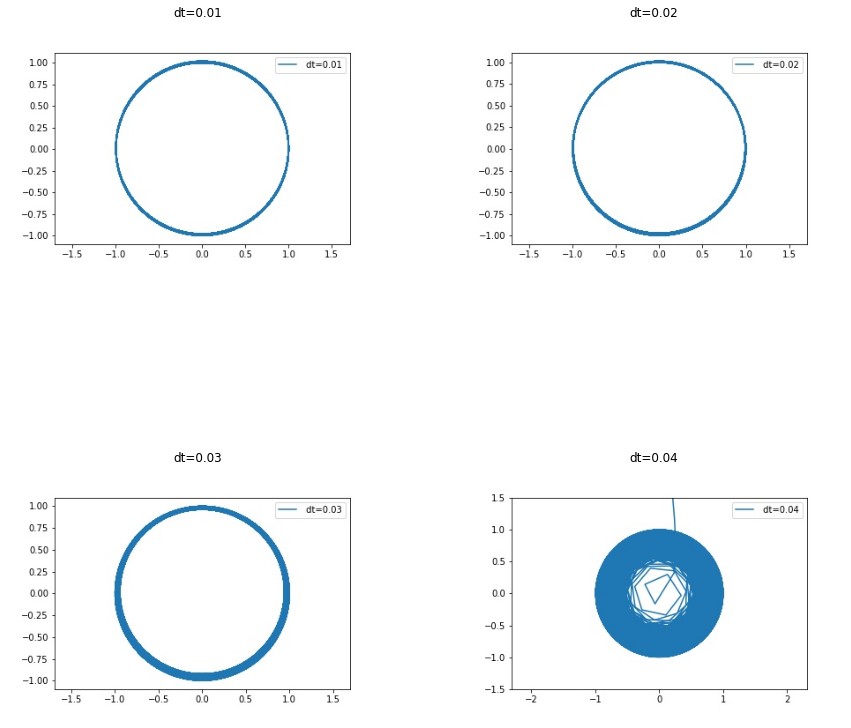

In [8]:
import matplotlib.image as mpimg

img=[]

for i in range(4):
    img.append(mpimg.imread(f"rk4_0.0{i+1}.jpeg" ))

fig=plt.figure(figsize=(15,15))
for i in range(4):
    ax=fig.add_subplot(2,2,i+1)
    ax.set_title(f"dt={(i+1)/100.}")
    imgplot=plt.imshow(img[i])
    plt.axis("off")
    
    

Donde se observa como se rompen las orbitas para dt>0.04, y la tierra sale disparada. 

Ahora para estos mismos valores se presentan las graficas de $|\frac{\Delta E}{E}|$ y $|\frac{\Delta L}{L}|$

## Energia

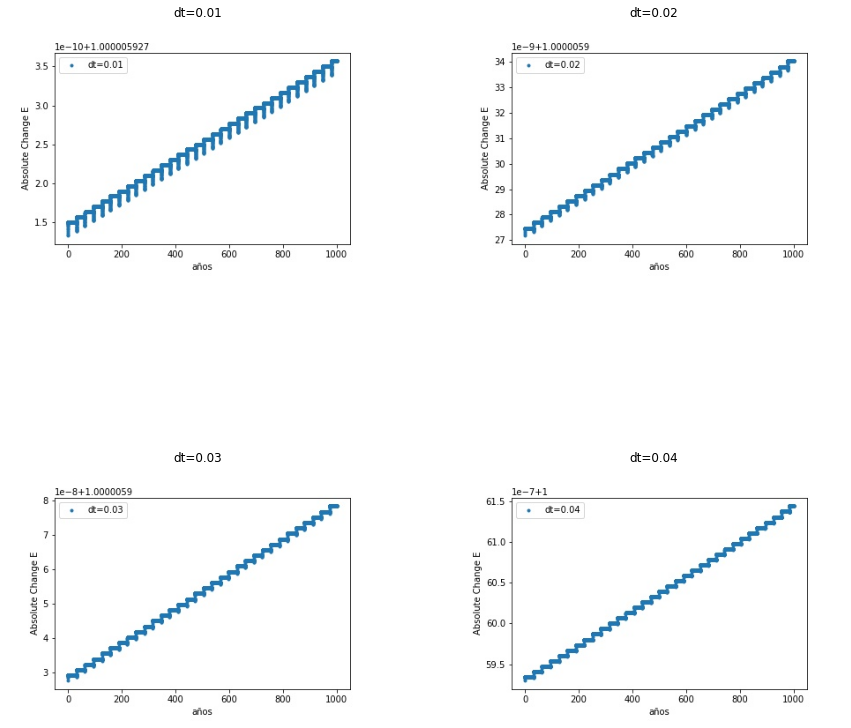

In [10]:
import matplotlib.image as mpimg

img=[]

for i in range(4):
    img.append(mpimg.imread(f"Rk4_0.0{i+1}_E.jpeg" ))

fig=plt.figure(figsize=(15,15))
for i in range(4):
    ax=fig.add_subplot(2,2,i+1)
    ax.set_title(f"dt={(i+1)/100.}")
    imgplot=plt.imshow(img[i])
    plt.axis("off")

## Momento Angular


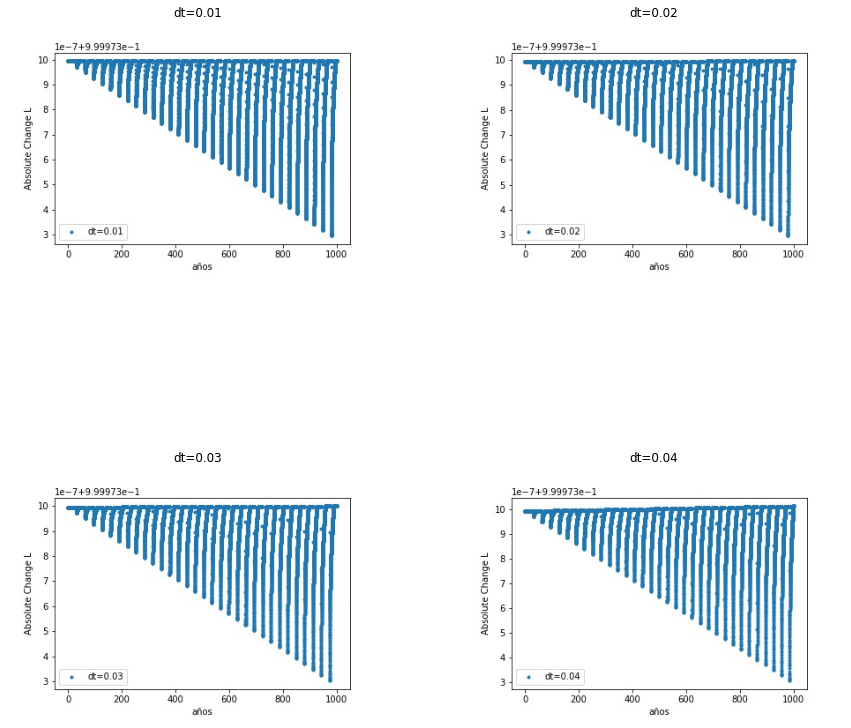

In [12]:
import matplotlib.image as mpimg

img=[]

for i in range(4):
    img.append(mpimg.imread(f"Rk4_0.0{i+1}_L.jpeg" ))

fig=plt.figure(figsize=(15,15))
for i in range(4):
    ax=fig.add_subplot(2,2,i+1)
    ax.set_title(f"dt={(i+1)/100.}")
    imgplot=plt.imshow(img[i])
    plt.axis("off")

## Leap-Frog

El algoritmo de leap frog es un algoritmo simplectico el cual conserva el area en el espacio de fase, puesto que se va a usar la energia y el momento angular como medidas de control es necesario usar una version modificada de leapfrog (velocity-verlet) que actualiza tambien la velocida cada paso de tiempo,los pasos de actualizacion son:
\begin{align}
v_{n+1/2}&=v_{n}+hF(x_{n})/2 \\
x_{n+1}&=x_{n}+hv_{n+1/2} \\
v_{n+1}&=v_{n+1/2}+hF(x_{n+1})/2 
\end{align}

El integrador en este caso esta dado por:

In [ ]:
def calcular_fuerzas(r,mass):
    f=np.zeros_like(r)
    N=len(mass)
    
    for i in range(N):
        for j in range(i):
            xij=r[i,:]-r[j,:]
            Fij=-G*mass[i]*mass[j]*xij/(np.linalg.norm(xij)**3)
            f[i]+=Fij
            f[j]+=-Fij
    return f


def leap_frog(q,mass,dt,ti,tf):
    

    #time grid
    t=np.arange(ti,tf,dt)
    dt=t[1]-t[0]
    #number of points
    N=len(t)
    
    #saving energy and angular momentum
    Delta_Energy=np.zeros(N)
    Delta_L=np.zeros(N)

    

    #time evolution
    for i in range(N):
        #save old energy and angular momentum
        old_TE=total_energy(q,mass).copy()
        old_L=total_L(q,mass).copy()
        #advance in time
        F1=calcular_fuerzas(q[:,:3],mass)
        q[:,3:]+=dt*(F1/mass.reshape(-1,1))/2.
        q[:,:3]+=dt*q[:,3:]/2
        F2=calcular_fuerzas(q[:,:3],mass)
        q[:,3:]+=dt*(F2/mass.reshape(-1,1))/2
        
        #save new energy and angular momentum
        new_TE=total_energy(q,mass).copy()
        new_L=total_L(q,mass).copy()
        #save delta_E and delta_L
        Delta_Energy[i]=np.abs((new_TE-old_TE)/old_TE)
        Delta_L[i]=np.abs((new_L-old_L)/old_L)
        

        
    
    return (t,Delta_Energy,Delta_L)

A continuacion se presentan las orbitas para algunos valores de dt

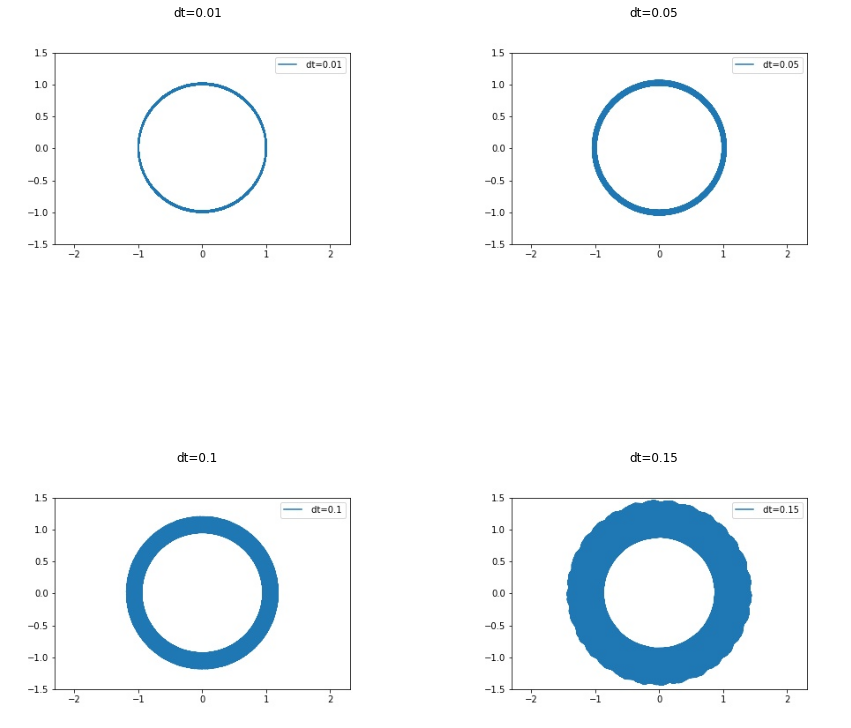

In [13]:
import matplotlib.image as mpimg

img=[]
data_dt=[0.01,0.05,0.1,0.15]

for i in range(4):
    img.append(mpimg.imread(f"lpf_{data_dt[i]}.jpeg" ))

fig=plt.figure(figsize=(15,15))
for i in range(4):
    ax=fig.add_subplot(2,2,i+1)
    ax.set_title(f"dt={data_dt[i]}")
    imgplot=plt.imshow(img[i])
    plt.axis("off")

Donde se observa como se rompen las orbitas para dt>0.15. 

Ahora para estos mismos valores se presentan las graficas de $|\frac{\Delta E}{E}|$ y $|\frac{\Delta L}{L}|$

## Energia

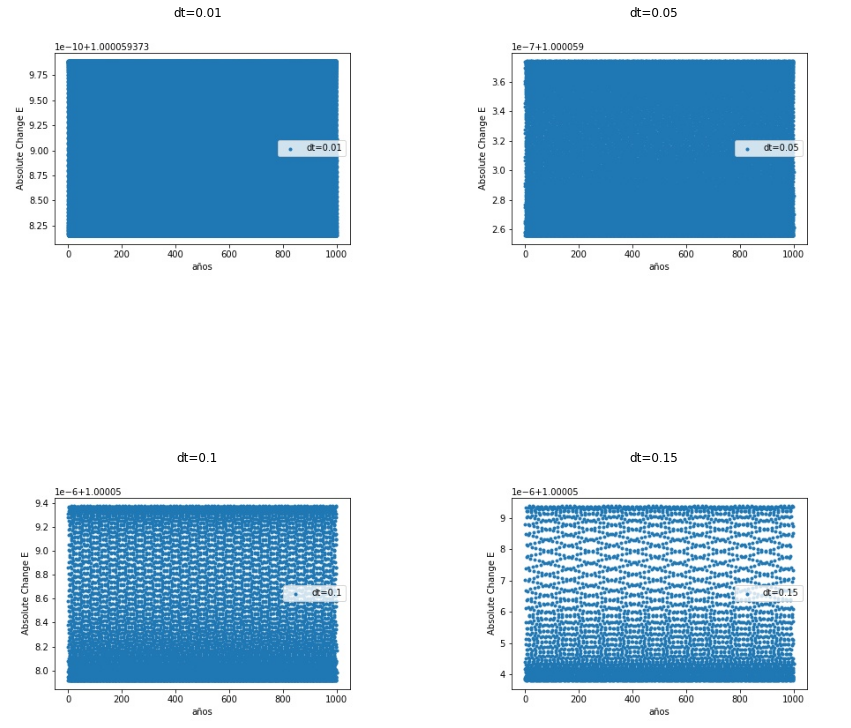

In [15]:
import matplotlib.image as mpimg

img=[]
data_dt=[0.01,0.05,0.1,0.15]

for i in range(4):
    img.append(mpimg.imread(f"lpf_{data_dt[i]}_E.jpeg" ))

fig=plt.figure(figsize=(15,15))
for i in range(4):
    ax=fig.add_subplot(2,2,i+1)
    ax.set_title(f"dt={data_dt[i]}")
    imgplot=plt.imshow(img[i])
    plt.axis("off")

## Momento Angular

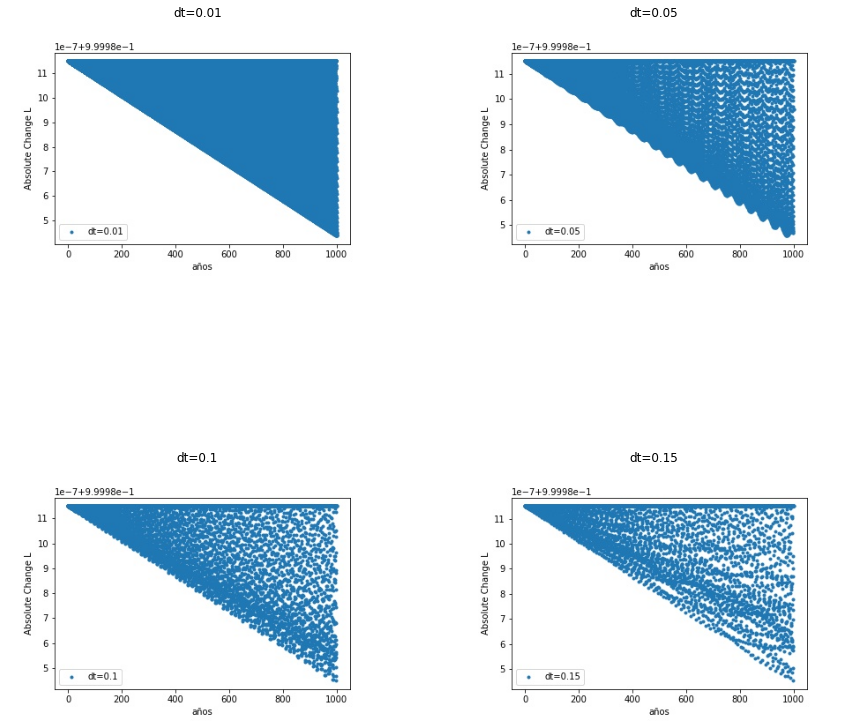

In [17]:
import matplotlib.image as mpimg

img=[]
data_dt=[0.01,0.05,0.1,0.15]

for i in range(4):
    img.append(mpimg.imread(f"lpf_{data_dt[i]}_L.jpeg" ))

fig=plt.figure(figsize=(15,15))
for i in range(4):
    ax=fig.add_subplot(2,2,i+1)
    ax.set_title(f"dt={data_dt[i]}")
    imgplot=plt.imshow(img[i])
    plt.axis("off")

### Conclusiones

A la hora de la implementacion aunque Rk4 da mejores resultados depende de un dt mas pequeño y el tiempo de calculo es mayor mientras leapfrog no tarda mucho y se mantienen las orbitas vivas mas tiempo 

---

## Eccentricidad


---
Para la excentricidad se calcula usando la formula:


\begin{align}
e=\sqrt{1+\frac{2EL^{2}}{m_{red}(Gm_{1}m_{2})^{2}}}
\end{align}

Para determinar la condicion inicial necesaria para obtener la excentricidad se determina con un metodo de root finding

In [18]:
#initial conditions 
x=np.array([0,1])
y=np.array([0,0])
z=np.array([0,0])
vx=np.array([0,0])
vy=np.array([0,6.27776068])
vz=np.array([0,0])
mass=np.array([1,3.00273e-6])
q0= np.array((x,y,z,vx,vy,vz)).transpose()
def ecc(q,mass,v,e0=0):
    #set vy velocity
    q0[1,4]=v
    E=total_energy(q,mass)
    L=total_L(q,mass)
    miu=(mass[0]*mass[1])/(mass[0]+mass[1])
    e=np.sqrt(1+(2*E*L**2)/(miu*(G*mass[0]*mass[1])**2))
    return e-e0


In [19]:
from scipy import optimize 
root1=optimize.newton(lambda x:ecc(q0,mass,x,0.7),7)

con esas velocidades iniciales se presentan las orbitas obtenidas para e=[0.25,0.5,0.75,0.9]

### Rk4

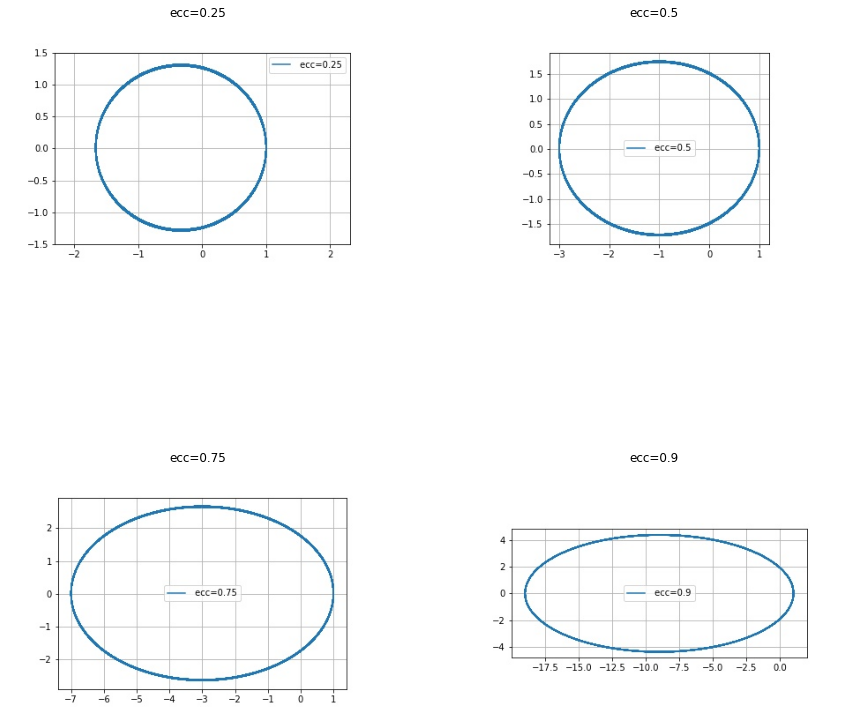

In [20]:
import matplotlib.image as mpimg

img=[]
ecc0=[0.25,0.5,0.75,0.9]

for i in range(4):
    img.append(mpimg.imread(f"rk4_{ecc0[i]}ecc.jpeg" ))

fig=plt.figure(figsize=(15,15))
for i in range(4):
    ax=fig.add_subplot(2,2,i+1)
    ax.set_title(f"ecc={ecc0[i]}")
    imgplot=plt.imshow(img[i])
    plt.axis("off")

### leap frog

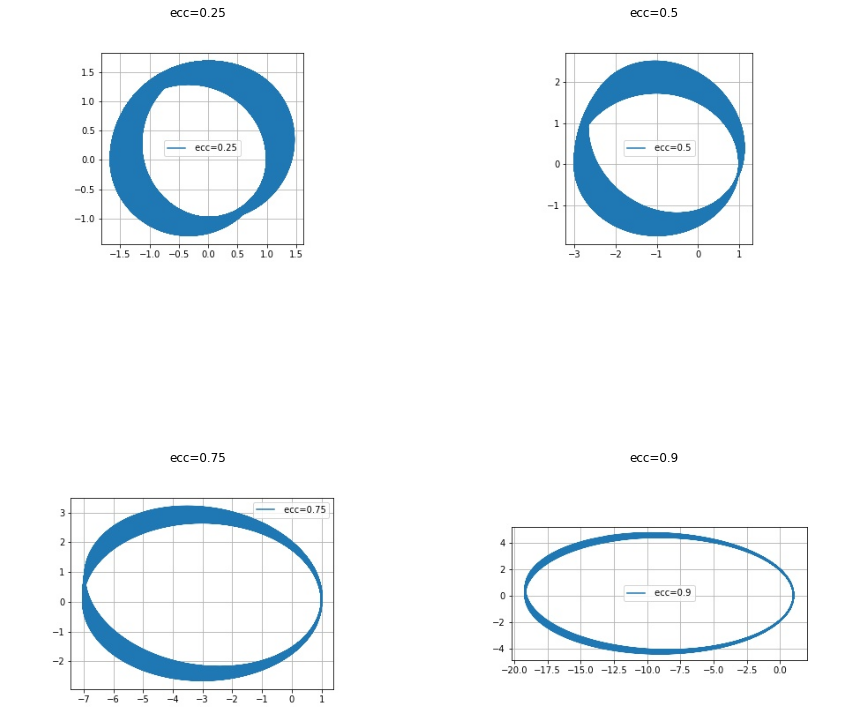

In [21]:
import matplotlib.image as mpimg

img=[]
ecc0=[0.25,0.5,0.75,0.9]

for i in range(4):
    img.append(mpimg.imread(f"lpf_{ecc0[i]}ecc.jpeg" ))

fig=plt.figure(figsize=(15,15))
for i in range(4):
    ax=fig.add_subplot(2,2,i+1)
    ax.set_title(f"ecc={ecc0[i]}")
    imgplot=plt.imshow(img[i])
    plt.axis("off")

Como se observa para leap frog ocurre un desplazamiento de las orbitas para excentricidades pequeñas, estas graficas fueron hechas con dt=0.01 y 1e3 años